# Aplikacja Tomografu
## Paweł Mazurkiewicz 156145
## Filip Michalski 155947

Przetwarzam plik: ./images/Kropka.dcm


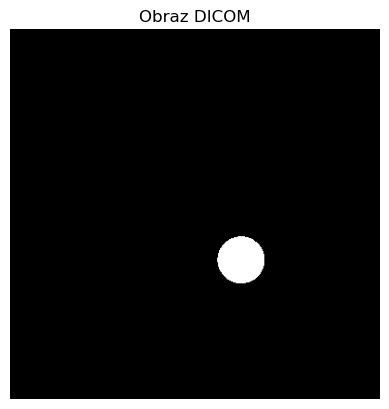

Przetwarzam plik: ./images/CT_ScoutView.dcm


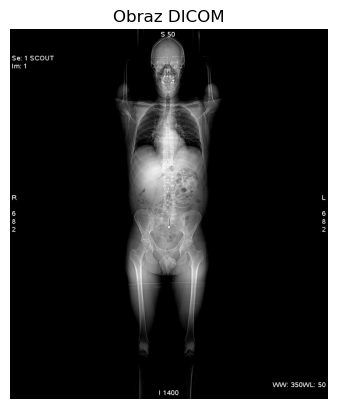

Przetwarzam plik: ./images/SADDLE_PE.dcm


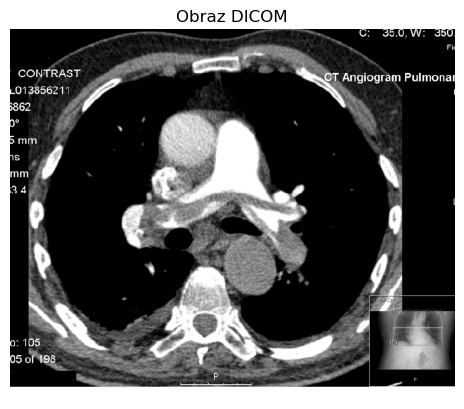

Przetwarzam plik: ./images/CT_ScoutView-large.dcm


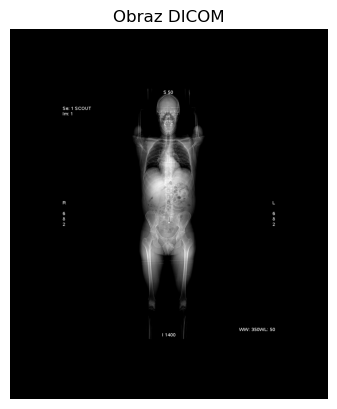

Przetwarzam plik: ./images/shepp_logan.dcm


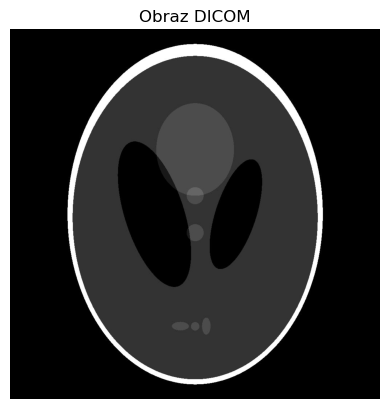

Przetwarzam plik: ./images/Kwadraty2.dcm


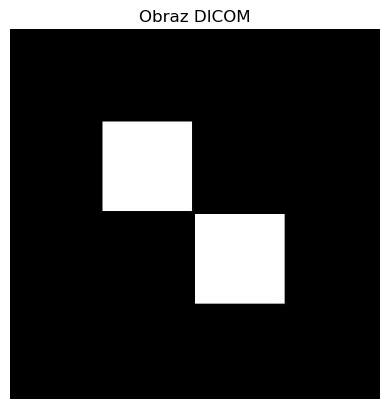

Przetwarzam plik: ./images/SADDLE_PE-large.dcm


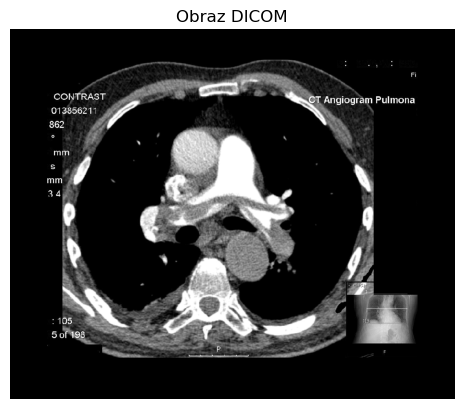

Przetwarzam plik: ./images/Paski2.dcm


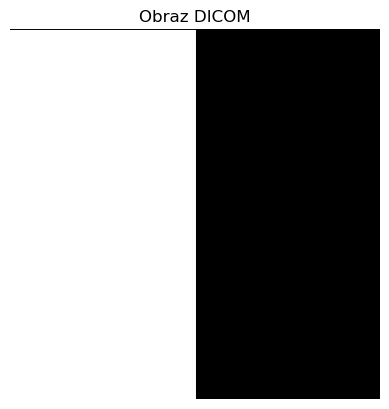

Przetwarzam plik: ./images/Kolo.dcm


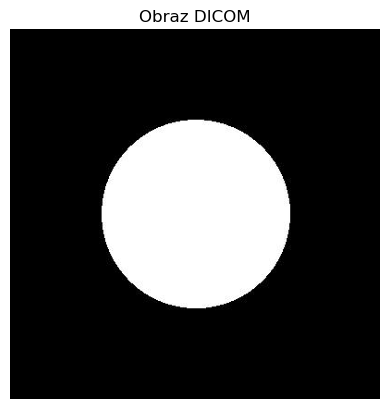

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os

folder_path = "./images"
dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))


for file_path in dicom_files:
    print(f"Przetwarzam plik: {file_path}")

    ds = pydicom.dcmread(file_path)

    pixel_array = ds.pixel_array

    normalized = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)

    # Wyświetlenie obrazu
    plt.imshow(normalized, cmap='gray')
    plt.title("Obraz DICOM")
    plt.axis("off")
    plt.show()
